In [16]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
import h5py
from sklearn.model_selection import train_test_split
import pandas as pd
import nltk
import os
import numpy as np
from wordcloud import WordCloud

In [17]:
# simple way to load the complete dataset (for a more sophisticated generator example, see LLD-logo script)
# open hdf5 file
hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
# load data into memory as numpy array
images, labels = (hdf5_file['data'][:], hdf5_file['labels/resnet/rc_64'][:])
real_logos = images

# Normalize pixel values to the range [0, 1]
real_logos = real_logos.astype('float32') / 255.0
# Split the data into training and validation sets
train_data, val_data = train_test_split(real_logos, test_size=0.2, random_state=42)


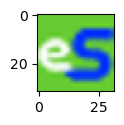

In [18]:
# Investigate the icon data using matplotlib
fig = plt.figure(figsize=(1, 1))
plt.imshow(np.transpose(images[20], (1, 2, 0)))

In [19]:
# Initiate a GAN model using tensorflow & keras
# Generator
latent_dim = 100
generator = keras.Sequential()
generator.add(layers.Dense(256, activation="relu", input_dim=latent_dim))
generator.add(layers.Dense(512, activation="relu", input_dim=latent_dim))
generator.add(layers.Dense(1024, activation="relu", input_dim=latent_dim))
generator.add(layers.Dense(32*32*3, activation="relu", input_dim=latent_dim))
generator.add(layers.Reshape((32, 32, 3)))

# Discriminator
discriminator = keras.Sequential()
discriminator.add(layers.Flatten(input_shape=(32, 32, 3)))
discriminator.add(layers.Dense(1024, activation='relu'))
discriminator.add(layers.Dense(512, activation='relu'))
discriminator.add(layers.Dense(256, activation='relu'))
discriminator.add(layers.Dense(1, activation='sigmoid'))

# Discriminator Network
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# Create the GAN model
discriminator.trainable = False
gan = keras.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [20]:
def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

# Create a function to generate a batch of fake images
def generate_fake_samples(generator, n_samples, noise_dim):
    noise = generate_noise(n_samples, noise_dim)
    fake_logos = generator.predict(noise)
    return fake_logos

# Train the GAN model
def train_gan(generator, discriminator, gan, train_data, n_epochs, n_batches, batch_size, latent_dim):
    for epoch in range(n_epochs):
        for batch in range(n_batches):
            start_index = batch * batch_size
            end_index = min((batch + 1) * batch_size, train_data.shape[0])
            batch_indices = np.arange(start_index, end_index)
            real_batch = train_data[batch_indices]
            real_batch = np.transpose(real_batch, (0, 2, 3, 1))

            noise = generate_noise(real_batch.shape[0], latent_dim)
            fake_batch = generator.predict(noise)

            X = np.concatenate([real_batch, fake_batch])
            y = np.concatenate([np.ones((real_batch.shape[0], 1)), np.zeros((real_batch.shape[0], 1))])
            discriminator_loss = discriminator.train_on_batch(X, y)

            # Train the Generator
            noise = generate_noise(real_batch.shape[0], latent_dim)
            y = np.ones((real_batch.shape[0], 1))
            generator_loss = gan.train_on_batch(noise, y)

    # Print the loss at the end of each epoch
    print(f'Epoch {epoch + 1}/{n_epochs} - Discriminator Loss: {discriminator_loss} - Generator Loss: {generator_loss}')
            

In [21]:
n_epochs = 10
batch_size = 10000
n_batches = int(np.ceil(train_data.shape[0] / batch_size))

train_gan(generator, discriminator, gan, train_data, n_epochs, n_batches, batch_size, latent_dim)

313/313 [==============================] - 1s 4ms/step


KeyboardInterrupt: 

In [ ]:
test = train_data[0:1]